# Практическая работа №2

**Цель:** изучение архитектур сверточных нейронных сетей, технологии переноса обучения; создание и исследование моделей сверточных нейронных сетей для задачи классификации.

**Задание:** построить классификатор для классификации изображений. Классификатор должен предсказывать есть ли на фотографии трещина. Датасет вы можете скачать по ссылке: https://www.kaggle.com/arunrk7/surface-crack-detection

In [1]:
import os

import torch
import pandas as pd
import numpy as np
import seaborn as sn
import cv2 as cv
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch import nn, optim
from torchvision import transforms, utils, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


import warnings
warnings.filterwarnings("ignore")

In [2]:
class SurfaceCrackDataset(Dataset):
    
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_name = ["Negative", "Positive"]
        self.img_path_list = []
        for one_class in self.target_name:
            count_img = list(os.listdir(os.path.join(root_dir,
                                                     one_class)))
            for img in count_img:
                self.img_path_list.append(os.path.join(one_class,img))
        self.img_list = np.empty([len(self.img_path_list), 227, 227, 3], dtype=np.uint8)
        for i, path in enumerate(self.img_path_list):
            self.img_list[i] = self.__get_img_by_path(os.path.join(root_dir, path))
            
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        target = self.target_name.index(os.path.dirname(self.img_path_list[index]))
        sample = {'image': self.img_list[index], 'target': target}
    
        if self.transform:
            sample["image"] = self.transform(self.img_list[index])
    
        return sample
    
    def __get_img_by_path(self, img_path):
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = np.array(img)
        return img

In [3]:
dataset = SurfaceCrackDataset("dataset", 
                       transform = transforms.Compose([
                                    transforms.ToTensor()]))

In [5]:
def show_data(df):
    """
    Отображение данных.
    Показывается первые три картинки из набора данных.
    """
    fig = plt.figure(figsize=(13,13))


    for i in range(0,len(df),2000):
        sample = df[i]

        print(i, sample['image'].shape, sample['target'])
        i = int(i/2000)
        ax = plt.subplot(1, 4, i + 1)
        plt.tight_layout()
        ax.set_title('Sample {}'.format(i))
        ax.axis('off')
        plt.imshow(sample['image'].numpy().transpose((1, 2, 0)))
        if i == 3:
            plt.show()
            break


0 torch.Size([3, 227, 227]) 0
2000 torch.Size([3, 227, 227]) 0
4000 torch.Size([3, 227, 227]) 0
6000 torch.Size([3, 227, 227]) 0


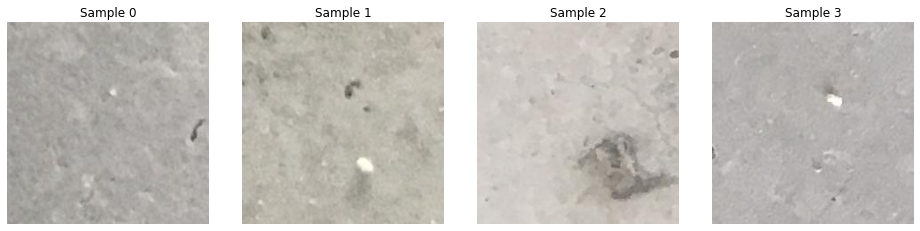

In [6]:
show_data(dataset)

In [7]:
# Классы
output_mapping = {
    0: "Negative",
    1: "Positive"
}

In [8]:
from collections import Counter
# Распределение классов
cnt_dataset = Counter([dataset[i]['target']for i in range(0,len(dataset))])

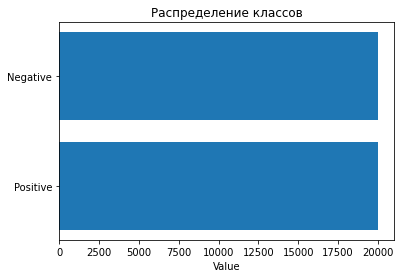

In [9]:
fig, ax = plt.subplots()
label = [output_mapping[j] for j in range(0,2)]
value = [cnt_dataset[j] for j in range(0,2)]
ax.barh(label, value, align='center')
ax.invert_yaxis()
ax.set_xlabel('Value')
ax.set_title('Распределение классов')
plt.show()

In [10]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
valid_size = int(0.2 * dataset_size)
test_size  = int(0.1 * dataset_size)
print(f'Размер dataseta: {dataset_size}')

Размер dataseta: 40000


**Разделение выборки на обучение, валидацию и тест**

In [11]:
train, valid, test = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])
print(f'Размер train: {len(train)}')
print(f'Размер valid: {len(valid)}')
print(f'Размер test: {len(test)}')

Размер train: 28000
Размер valid: 8000
Размер test: 4000


In [12]:
train_dl = DataLoader(train, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid, batch_size=16, shuffle=True)
test_dl = DataLoader(test, batch_size=16, shuffle=True)

## Обучение сверточных нейронных сетей

In [13]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
device

device(type='cuda')

In [14]:
def fit(model, loss_func, opt, train_dl, valid_dl, epochs = 10):
    """
    Обучение сети.
    
    :param model: модуль для обучения.
    :param loss_func: функция потерь.
    :param opt: оптимизатор сети.
    :param train_dl: обучающая выборка.
    :param valid_dl: валидауионная выборка.
    :param epochs: количество эпох.
    
    :return train_losses: значение loss-функции на обучение каждую эпоху.
    :return val_losses: значение loss-функции на валидациии каждую эпоху.
    :return valid_accuracies: значение точности на валидации каждую эпоху.
    """
    
    train_losses = []
    val_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for target in tqdm(train_dl):
            xb, yb = target['image'].to(device), target['target'].to(device)
            loss = loss_func(model(xb), yb)
            loss_sum += loss.item()
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_sum / len(train_dl))

        model.eval()
        loss_sum = 0
        correct = 0
        num = 0
        with torch.no_grad():
            for target in tqdm(valid_dl):
                xb, yb = target['image'].to(device), target['target'].to(device)
                
                probs = model(xb)
                loss_sum += loss_func(probs, yb).item()
                
                _, preds = torch.max(probs, axis=-1)
                correct += (preds == yb).sum().item()
                num += len(xb)
                
        val_losses.append(loss_sum / len(valid_dl))
        valid_accuracies.append(correct / num)
        
    return train_losses, val_losses, valid_accuracies

In [15]:
def plot_trainig(train_losses, valid_losses, valid_accuracies):
    """
    Графики обучения.
    
    :param train_losses: значение loss-функции на обучение каждую эпоху.
    :param val_losses: значение loss-функции на валидациии каждую эпоху.
    :param valid_accuracies: значение точности на валидации каждую эпоху.
    """
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(train_losses, label="train_loss")
    plt.plot(valid_losses, label="valid_loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

## 1. CNN

In [26]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128,256,3)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(36864, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.bn1(F.max_pool2d(F.relu(self.conv1(x)), 2))
        x = self.bn2(F.max_pool2d(F.relu(self.conv2(x)), 2))
        x = self.bn3(F.max_pool2d(F.relu(self.conv3(x)), 2))
        x = self.bn4(F.max_pool2d(F.relu(self.conv4(x)), 2))
        x = x.view(x.shape[0], -1)
        x =  self.fc1(x)
        x = self.fc2(x)
        return x

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 32.50it/s]


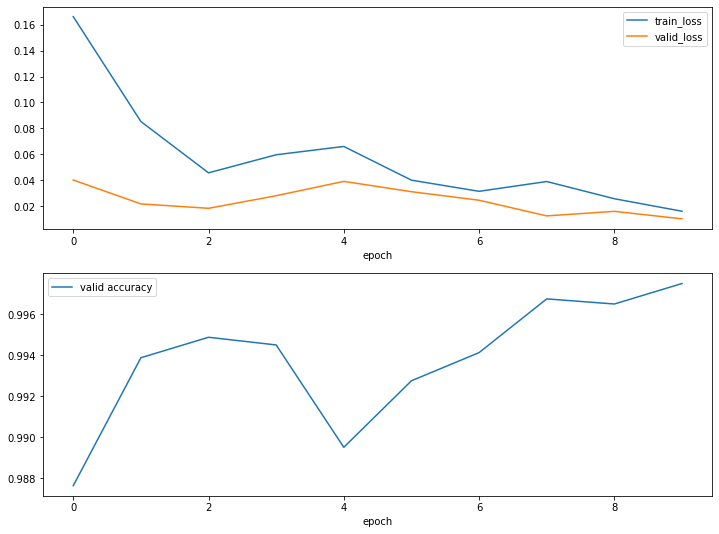

In [27]:
model = Model().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model_inf = fit(model, loss_fn, optimizer, train_dl, valid_dl, 10)
plot_trainig(*model_inf)

# ResNet

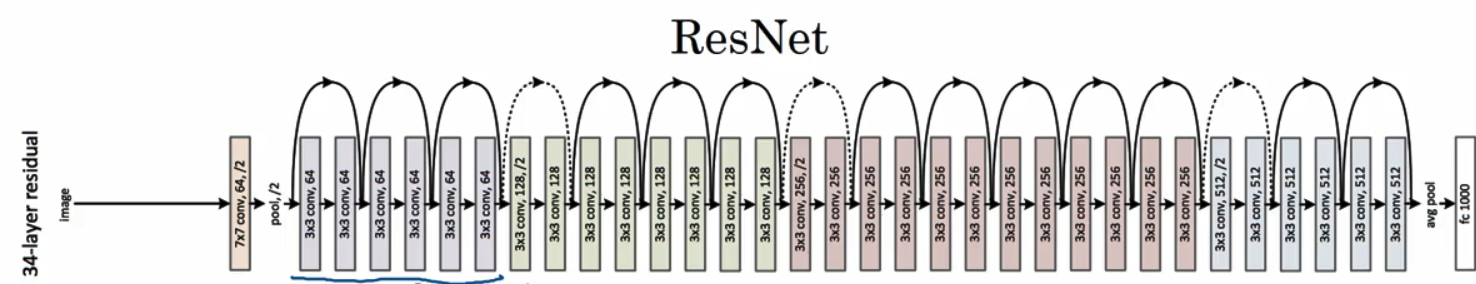

In [35]:
resnet18 = models.resnet18(pretrained=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.29it/s]


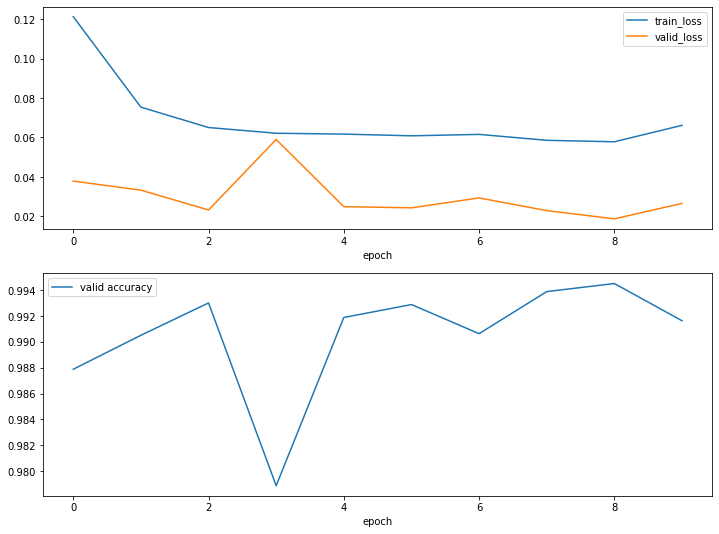

In [36]:
# Заморозка всех слоев
for param in resnet18.parameters():
    param.requires_grad = False

resnet18.fc = nn.Linear(in_features=512, out_features=2, bias=True)
    
resnet18 = resnet18.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

resnet18_inf = fit(resnet18, loss_fn, optimizer, train_dl, valid_dl, 10)
plot_trainig(*resnet18_inf)

**ResNet18 с 3 размороженными слоями слоями**

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:20<00:00, 24.07it/s]


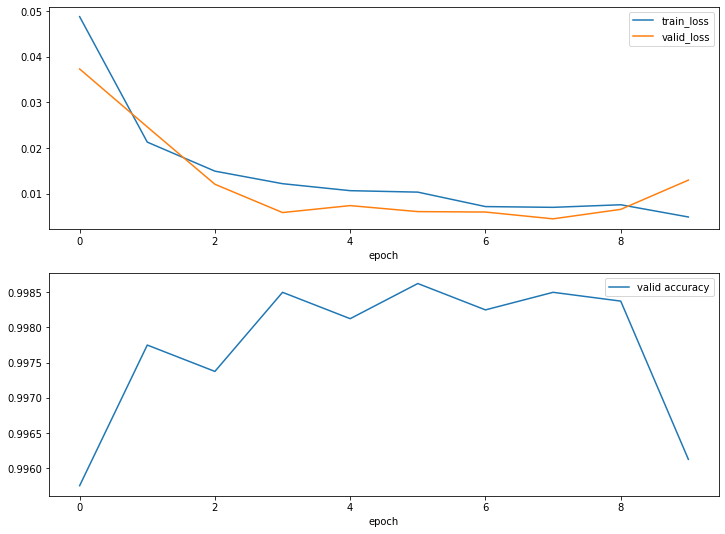

In [38]:
resnet18_two = models.resnet18(pretrained=True)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet18_two.parameters():
    param.requires_grad = False

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet18_two.parameters():
    param.requires_grad = False
#разморозили три слоя слой  
for param in resnet18_two.layer2.parameters():
    param.requires_grad = True
for param in resnet18_two.layer3.parameters():
    param.requires_grad = True
for param in resnet18_two.layer4.parameters():
    param.requires_grad = True    
    
resnet18_two.fc = nn.Linear(in_features=512, out_features=2, bias=True)
    
resnet18_two = resnet18_two.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(resnet18_two.layer2.parameters()) + 
                       list(resnet18_two.layer3.parameters()) +
                       list(resnet18_two.layer4.parameters()) +
                       list(resnet18_two.fc.parameters()), lr=0.01)

resnet18_two_inf = fit(resnet18_two, loss_fn, optimizer, train_dl, valid_dl, 8)
plot_trainig(*resnet18_two_inf)

## AlexNet

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 53.25it/s]


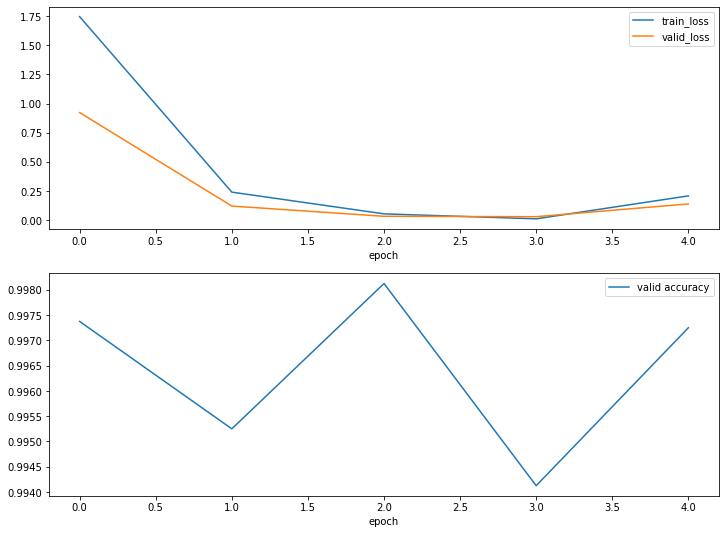

In [40]:
model_alex = models.alexnet(pretrained=True)
for param in model_alex.parameters():
    param.requires_grad = False

model_alex.classifier = nn.Sequential(
    nn.Linear(in_features=9216, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=2, bias=True),
  )

model_alex = model_alex.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_alex.parameters(), lr=0.01)
model_alex_inf = fit(model_alex, loss_fn, optimizer, train_dl, valid_dl, 10)
plot_trainig(*model_alex_inf)

# Качества модели

In [41]:
list_model = [model, resnet18, resnet18_two, model_alex]
model_name = ["MeModel", "ResNet18 + all Freeze", "ResNet18 + 3 layer Freeze", "AlexNet + all Freeze"]

In [43]:
# тестирование полученных моделей
test_accuracies = []
for i, model in enumerate(list_model):
    model.eval()
    correct = 0
    num = 0
    with torch.no_grad():
        for target in tqdm(test_dl):
            xb, yb = target['image'].to(device), target['target'].to(device)

            probs = model(xb)

            _, preds = torch.max(probs, axis=-1)
            correct += (preds == yb).sum().item()
            num += len(xb)

    test_accuracies.append(correct / num)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 54.87it/s]


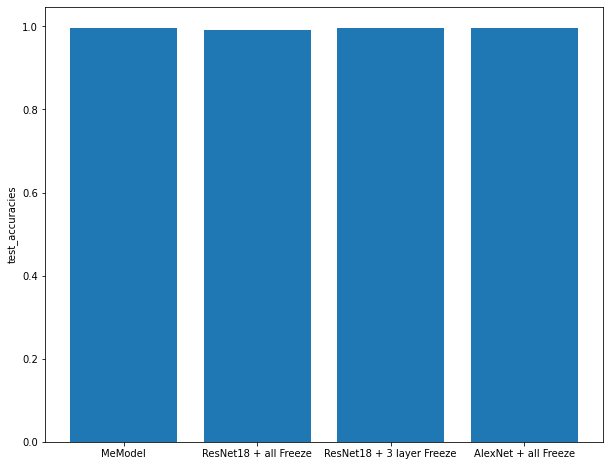

accuracies: [0.997, 0.99025, 0.9955, 0.99675]


In [45]:
plt.figure(figsize =(10, 8))
plt.subplot(1, 1, 1)
plt.ylabel("test_accuracies")
plt.bar(model_name, test_accuracies)
      
plt.show()
print("accuracies:",test_accuracies)

# Матрица ошибок для лучшей модели

In [46]:
best_model_confusion_matrix = np.zeros((2, 2))
for i, model in enumerate([model]):
    model.eval()
    with torch.no_grad():
        for target in tqdm(test_dl):
            xb, yb = target['image'].to(device), target['target'].to(device)

            probs = model(xb)

            _, preds = torch.max(probs, axis=-1)
            best_model_confusion_matrix += confusion_matrix(yb.cpu().numpy(), preds.cpu().numpy())

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 29.97it/s]


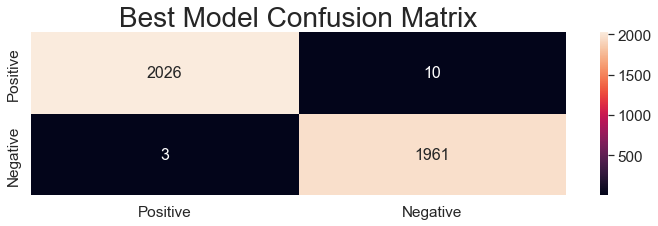

In [59]:
Labels = ["Positive", "Negative"]
plt.figure(figsize=(12, 3))

df_cm = pd.DataFrame(best_model_confusion_matrix.astype(int), Labels, Labels)

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size
plt.title('Best Model Confusion Matrix', fontsize=28) 
   
plt.show() 